In [92]:
# Solution to Exercise 6.3.

import sys
import math
import numpy as np
import matplotlib.pyplot as plt

# def initialize(n, seed, v0):
#     mass = np.ones(n)/n
#     pos = np.zeros((n,3))
#     vel = np.zeros((n,3))
#     if n == 2:
#         pos = np.array([[1.0,0,0],[-1.0,0,0]])
#         vel = np.array([[0,v0,0],[0,-v0,0]])
#     return mass,pos,vel

def initialize(n, seed, v0):
    mass = np.ones(n)/n
    mass_for_cm = np.ones((n,1))/n

    pos = np.zeros((n,3))
    vel = np.zeros((n,3))

    q = np.random.random(n)
    r = q**(1./3)
    mu = 2*np.random.random(n) - 1
    theta = np.arccos(mu)
    phi = 2*np.pi*np.random.random(n)
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)

    pos[:,0] = x * r
    pos[:,1] = y * r
    pos[:,2] = z * r

    r = v0
#     mu = 2*np.random.random(n) - 1
#     theta = np.arccos(mu)
#     phi = 2*np.pi*np.random.random(n)
#     vx = r*np.sin(theta)*np.cos(phi)
#     vy = r*np.sin(theta)*np.sin(phi)
#     vz = r*np.cos(theta)

    vx = r * x
    vy = r * y
    vz = r * z

    vel[:,0] = vx
    vel[:,1] = vy
    vel[:,2] = vz

    M = mass.sum()

    rcm = (1/M)*(mass_for_cm*pos).sum(axis = 0)
    vcm = (1/M)*(mass_for_cm*vel).sum(axis = 0)  

    pos = pos - rcm
    vel = vel - vcm
    
    return mass,pos,vel


    
def potential_energy(mass, pos, eps2):
    n = len(mass)
    pot = 0.0
    dx = np.zeros((n,3))
    for i in range(n):
        dx[i+1:] = pos[i+1:] - pos[i]
        dr2 = (dx[i+1:]**2).sum(axis=1) + eps2
        pot -= mass[i]*(mass[i+1:]/np.sqrt(dr2)).sum()
    return pot

def alt_potential_energy(mass, pos, eps2):
    n = len(mass)
    pot = 0.0
    for i in range(n):
        for j in range(i+1,n):
            dr2 = eps2
            for k in range(3):
                dr2 += (pos[i,k]-pos[j,k])**2
            pot -= mass[i]*mass[j]/math.sqrt(dr2)
    return pot

def kinetic_energy(mass, vel):
    return 0.5*(mass*(vel**2).sum(axis=1)).sum()

def alt_kinetic_energy(mass, vel):
    n = len(mass)
    kin = 0.0
    for i in range(n):
        vi2 = 0.0
        for k in range(3):
            vi2 += vel[i,k]**2
        kin += 0.5*mass[i]*vi2
    return kin

def energy(mass, pos, vel, eps2):
    T = kinetic_energy(mass, vel)
    U = potential_energy(mass, pos, eps2)
    return T+U

def output(t, E0, mass, pos, vel, eps2, steps):
    E = energy(mass, pos, vel, eps2)
    print('t =', t, 'dE =', E-E0, 'steps =', steps)

def acceleration(mass, pos, eps2):
    n = len(mass)
    acc = np.zeros((n,3))
    for i in range(n):
        dx   = pos - pos[i]
        dr2  = (dx**2).sum(axis=1) + eps2
        dr2i = 1./dr2
        dr3i = mass*np.sqrt(dr2i)*dr2i
        dx  *= dr3i.reshape(n,1)
        acc[i] = dx.sum(axis=0)
    return acc

def alt_acceleration(mass, pos, eps2):
    n = len(mass)
    acc = np.zeros((n,3))
    for i in range(n):
        for j in range(i+1,n):
            dr2 = eps2
            for k in range(3):
                dr2 += (pos[j,k]-pos[i,k])**2
            dr2i = 1./dr2
            dr3i = dr2i*math.sqrt(dr2i)
            for k in range(3):
                dxij = (pos[j,k]-pos[i,k])*dr3i
                acc[i,k] += mass[j]*dxij
                acc[j,k] -= mass[i]*dxij
    return acc

huge = 1.e20

def acceleration2(mass, pos, vel, eps2):
    n = len(mass)
    acc = np.zeros((n,3))
    tau = huge
    for i in range(n):
        dx = pos - pos[i]
        dr2 = (dx**2).sum(axis=1) + eps2
        dv = vel - vel[i]
        vdotx = np.abs((dx*dv).sum(axis=1)) + tiny
        dr3 = dr2*np.sqrt(dr2)
        dr3i = mass/dr3
        dx *= dr3i.reshape(n,1)
        acc[i] = dx.sum(axis=0)

        dr3[i] = huge
        tau2 = dr2/vdotx
        tau3 = dr3/(mass+mass[i])
        tau2[i] = huge
        tau3[i] = huge
        tau = min(tau, tau2.min(), math.sqrt(tau3.min()))

    return acc, tau

def alt_acceleration2(mass, pos, vel, eps2):
    n = len(mass)
    acc = np.zeros((n,3))
    tau = huge
    for i in range(n):
        for j in range(i+1,n):
            dr2 = eps2
            for k in range(3):
                dr2 += (pos[j,k]-pos[i,k])**2

            rij = math.sqrt(dr2)
            dvr = 0.
            for k in range(3):
                dvr += (pos[j,k]-pos[i,k])*(vel[j,k]-vel[i,k])
            vrij = dvr/rij
            
            dr2i = 1./dr2
            dr3i = dr2i*math.sqrt(dr2i)
            for k in range(3):
                dxij = (pos[j,k]-pos[i,k])*dr3i
                acc[i,k] += mass[j]*dxij
                acc[j,k] -= mass[i]*dxij

            da2 = 0.
            for k in range(3):
                da2 += (acc[j,k]-acc[i,k])**2
            aij = math.sqrt(da2)

            tau2ij = huge
            if vrij > 0: tau2ij = rij/vrij
            tau3ij = math.sqrt(rij/aij)

            tau = min(tau, tau2ij, tau3ij)

    return acc,tau

acc2 = acceleration2

def step(t, mass, pos, vel, eps2, dt):

    # Second-order predictor-corrector.

    acc,tau = acc2(mass, pos, vel, eps2)
    pos += dt*(vel+0.5*dt*acc)
    anew,tau = acc2(mass, pos, vel, eps2)
    vel += 0.5*dt*(acc+anew)
    return t+dt,pos,vel,tau

def orbital_elements(m1, m2, x1, x2, v1, v2, eps2):
    M = m1+m2
    x = x2-x1
    v = v2-v1
    r2 = (x**2).sum() + eps2
    v2 = (v**2).sum()
    E = 0.5*v2 - M/math.sqrt(r2)
    sma = -0.5*M/E
    h2 = ((np.cross(x,v))**2).sum()
    ecc = (1 + 2*E*h2/M**2)**0.5
    return sma, ecc, E, h2**0.5
    
tiny = 1.e-20
def main(N, seed, eps, dt, t_end, v0, eta):
    if eps <= 0.0: eps = tiny
    dt0 = dt

    # Initial conditions.

    t = 0.0
    mass,pos,vel = initialize(N, seed, v0)
    steps = 0
    acc,tau = acc2(mass, pos, vel, eps**2)
    dt = dt0*tau
    
    tau0 = tau
    
    # Initial diagnostics.
    
    E0 = energy(mass, pos, vel, eps**2)
    print('Initial E =', E0)
    output(t, E0, mass, pos, vel, eps**2, steps)
    a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0], pos[1],
                                  vel[0], vel[1], eps**2)
    print('semimajor axis =', a, ' eccentricity =', e)

    # Run forward to specified time.

    tplot = []
    dEplot = []
    hplot = []
    smaplot = []
    eccplot = []
    
    tot_E_plot = []
    tot_T_plot = []
    tot_U_plot = []
    virial_radius_plot = []
    tau_variation_plot = []
    
    max_error = .0001
    t_increment = 0
    

    while t < t_end-0.5*dt:
        t,pos,vel,tau = step(t, mass, pos, vel, eps**2, dt)
        steps += 1

        #dt = dt0
        #r = math.sqrt(((pos[1]-pos[0])**2).sum())
        #dt = dt0*r**1.5
        tau *= eta
        dt = dt0*tau													# <-- new

        E = energy(mass, pos, vel, eps**2)

        tplot.append(t)
        dEplot.append(E-E0)
        hplot.append(h)
        smaplot.append(a)
        eccplot.append(e)
        
            
        if t >= t_increment:
            t_increment += .5
            print('Energy error is = {} at t = {}'.format(abs(E - E0),t))
            print('dt = {}'.format(dt))

        if abs(E-E0) >= max_error:
            print('Error greater than max error = {}, error = {}, at t = {}'.format(max_error, abs(E-E0), t))
            print('dt = {}'.format(dt))
            break
            
#             j = 0
#             for i in range(50):
#                 temp_pos = np.concatenate(pos[i],j)

    # Final diagnostics.

    print('dt = {}'.format(dt))
    print('\nThe number of steps = {}'.format(np.size(tplot)))




In [4]:
N = 50
seed = 12345
eps = .005
dt = .01
t_end = 20
v0 = .1
eta = .5


main(N, seed, eps, dt, t_end, v0, eta)

Initial E = -0.5285209525685945
t = 0.0 dE = 0.0 steps = 0
semimajor axis = 1.9686327737874272  eccentricity = 0.6027562517609921
Energy error is = 5.968715521831314e-10 at t = 0.0007963942009361405
dt = 0.0003970521422272606
Energy error is = 1.5608137116096543e-08 at t = 0.5000184333082136
dt = 9.462761955580186e-05
Energy error is = 4.6573639744806883e-07 at t = 1.0000046648562642
dt = 9.132465531509402e-06
Energy error is = 4.4328050585740186e-07 at t = 1.500038834935594
dt = 6.0458456705641603e-05
Energy error is = 6.284593883076894e-07 at t = 2.0000307786664204
dt = 3.6958435458385104e-05
Energy error is = 3.8796911328020656e-07 at t = 2.5000505874165126
dt = 6.979260644985482e-05
Energy error is = 1.137418280894309e-06 at t = 3.0000085707920046
dt = 4.380076036167323e-05
Energy error is = 1.2776363096378418e-06 at t = 3.5000340903859213
dt = 3.659921252850799e-05
Energy error is = 1.2758924327060939e-06 at t = 4.0000064968312135
dt = 3.29195437197466e-05
Energy error is = 8.4621

In [93]:
tiny = 1.e-20
def main(N, seed, eps, dt, t_end, v0, eta):
    if eps <= 0.0: eps = tiny
    dt0 = dt

    # Initial conditions.

    t = 0.0
    mass,pos,vel = initialize(N, seed, v0)
    steps = 0
    acc,tau = acc2(mass, pos, vel, eps**2)
    dt = dt0*tau
    
    tau0 = tau
    
    # Initial diagnostics.
    
    E0 = energy(mass, pos, vel, eps**2)
    print('Initial E =', E0)
    output(t, E0, mass, pos, vel, eps**2, steps)
#     a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0], pos[1],
#                                   vel[0], vel[1], eps**2)
#     print('semimajor axis =', a, ' eccentricity =', e)

    # Run forward to specified time.

    tplot = []
    dEplot = []
    hplot = []
    smaplot = []
    eccplot = []
    
    tot_E_plot = []
    tot_T_plot = []
    tot_U_plot = []
    virial_radius_plot = []
    tau_variation_plot = []
    
    half_time_unit = 0
    

    while t < t_end-0.5*dt:
        t,pos,vel,tau = step(t, mass, pos, vel, eps**2, dt)
        steps += 1

        #dt = dt0
        #r = math.sqrt(((pos[1]-pos[0])**2).sum())
        #dt = dt0*r**1.5
        tau *= eta
        dt = dt0*tau													# <-- new

        E = energy(mass, pos, vel, eps**2)
#         a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0],
#                                       pos[1], vel[0], vel[1], eps**2)
        
        T = kinetic_energy(mass, vel)
        U = potential_energy(mass, pos, eps**2)
        R_virial = -(mass.sum()**2)/(2*U)
        variation_tau = tau - tau0
        tau0 = tau

        tot_E_plot.append(E)
        tot_T_plot.append(T)
        tot_U_plot.append(U)
        virial_radius_plot.append(R_virial)
        tau_variation_plot.append(variation_tau)
        

        tplot.append(t)
        dEplot.append(E-E0)
#         hplot.append(h)
#         smaplot.append(a)
#         eccplot.append(e)
#         print(E0/N)
        
        if t >= half_time_unit:
            print('\nTime = {}, Energy Error = {}\n'.format(t, abs(E - E0)))
            half_time_unit += .5
            number_of_bound_parts = 0
            
            for i_temp in range(N):
                for j_temp in range(i_temp + 1, N):
                    dr2 = eps**2
                    rel_U = 0
                    for k in range(3):
                        dr2 += (pos[i_temp,k]-pos[j_temp,k])**2
                        rel_U -= mass[i_temp]*mass[j_temp]/math.sqrt(dr2)
                        
                    rel_T = .5*mass[i_temp]*(vel[i_temp]**2).sum() + .5*mass[j_temp]*(vel[j_temp]**2).sum()
                    rel_E = rel_U + rel_T
#                     print(rel_U, rel_T, rel_E)
#                     print(E0/N)
                    
                    sma, ecc, E_orb, h2 = orbital_elements(mass[i_temp], mass[j_temp], 
                                                               pos[i_temp], pos[j_temp], 
                                                               vel[i_temp], vel[j_temp], eps**2)
#                     if E_orb < E0/N:
                    if rel_E < E0/N:
#                         print(i_temp, j_temp)
                        number_of_bound_parts += 1
                        rel_orbital_period = 2*np.pi*np.sqrt(abs(sma**3)/(2*mass[i_temp]))
                        print('Bound Particles {} and {} with orbital energy = {} and period = {}'.format(i_temp, j_temp,E_orb, rel_orbital_period))
            print('Number of Bound Partices = {}'.format(number_of_bound_parts))


    # Final diagnostics.
    
    print(t, abs(E - E0))
    print('Total time steps =', np.size(tplot))
    output(t, E0, mass, pos, vel, eps**2, steps)
    
    fig, ax = plt.subplots(2, 1, figsize = (8, 8))
    fig.suptitle('Question 1c') 
    plt.subplots_adjust(wspace=.25)

    
    ax[0].plot(tplot, tot_E_plot, label = 'Total Energy')
    ax[0].plot(tplot, tot_T_plot, label = 'Total Kinetic Energy')
    ax[0].plot(tplot, tot_U_plot, label = 'Total Potential Energy')
    ax[0].plot(tplot, virial_radius_plot, label = 'Virial Radius')
    
    ax[0].set(xlabel = 'x', title = 'Phase Portrait')
    ax[0].legend()

    ax[1].plot(tplot, tau_variation_plot)
    ax[1].set(xlabel = 't', ylabel = 'change in tau', title = 'Varation in tau')
    ax[1].set_yscale('log')

    plt.savefig('Q1c')

#     plt.subplot(2,2,1)
#     plt.plot(tplot, dEplot)
#     plt.xlabel('time')
#     plt.ylabel('energy error')

#     plt.subplot(2,2,2)
#     plt.plot(tplot, hplot)
#     plt.xlabel('time')
#     plt.ylabel('angular momentum')

#     plt.subplot(2,2,3)
#     plt.plot(tplot, smaplot)
#     plt.xlabel('time')
#     plt.ylabel('semimajor axis')

#     plt.subplot(2,2,4)
#     plt.plot(tplot, eccplot)
#     plt.xlabel('time')
#     plt.ylabel('eccentricity')

    plt.tight_layout()
    plt.show()

Initial E = -0.6064129818365092
t = 0.0 dE = 0.0 steps = 0

Time = 0.00021076121580155898, Energy Error = 1.6846857242569513e-11

Bound Particles 1 and 19 with orbital energy = -0.013329361512882575 and period = 57.740540630068516
Bound Particles 1 and 35 with orbital energy = -0.02188539968009421 and period = 27.444994163723273
Bound Particles 2 and 26 with orbital energy = -0.056695692449767125 and period = 6.582180238933649
Bound Particles 3 and 16 with orbital energy = -0.026701557151752636 and period = 20.365261123334335
Bound Particles 3 and 47 with orbital energy = -0.020309064870915293 and period = 30.70152696293065
Bound Particles 4 and 19 with orbital energy = -0.038048481720375414 and period = 11.972610913855394
Bound Particles 4 and 27 with orbital energy = -0.07082951557696977 and period = 4.713825037952042
Bound Particles 5 and 22 with orbital energy = -0.06906681231449055 and period = 4.895428906053877
Bound Particles 5 and 38 with orbital energy = -0.023098308185564957 


Time = 1.0000027762659485, Energy Error = 1.2554310755419351e-06

Bound Particles 1 and 4 with orbital energy = 0.4447581254148384 and period = 0.2995773877974793
Bound Particles 1 and 45 with orbital energy = 0.5063128428726651 and period = 0.2466416691170241
Bound Particles 2 and 7 with orbital energy = -0.47388938465065344 and period = 0.27238262164234694
Bound Particles 2 and 42 with orbital energy = 0.6388195962564563 and period = 0.17403136286920773
Bound Particles 3 and 26 with orbital energy = 0.22212267333425184 and period = 0.8488003081947552
Bound Particles 3 and 36 with orbital energy = -0.0054259792942285 and period = 222.31955679195653
Bound Particles 4 and 45 with orbital energy = 0.435837596812392 and period = 0.3088217142298281
Bound Particles 5 and 8 with orbital energy = 0.47897735562602906 and period = 0.2680540622866056
Bound Particles 5 and 13 with orbital energy = 1.2722228575544015 and period = 0.061922727160783314
Bound Particles 6 and 27 with orbital energy =


Time = 2.5000455671642037, Energy Error = 2.3448417822979906e-06

Bound Particles 1 and 19 with orbital energy = 0.351072126271873 and period = 0.4271696036848067
Bound Particles 3 and 6 with orbital energy = 0.8917061576031806 and period = 0.10552666610674562
Bound Particles 3 and 10 with orbital energy = 1.5935299132506908 and period = 0.0441727600028143
Bound Particles 3 and 26 with orbital energy = -0.47047363341812204 and period = 0.27535434381988894
Bound Particles 3 and 41 with orbital energy = 0.5821069261694087 and period = 0.20007402817959705
Bound Particles 3 and 42 with orbital energy = 0.7831114055322227 and period = 0.1282211129842773
Bound Particles 5 and 21 with orbital energy = 0.19928901818902336 and period = 0.9987799483598349
Bound Particles 5 and 23 with orbital energy = 0.6142878807861804 and period = 0.18455972963254258
Bound Particles 5 and 43 with orbital energy = 0.17777108095023625 and period = 1.1855044715488068
Bound Particles 5 and 47 with orbital energy 


Time = 3.5000038254925627, Energy Error = 1.920429127610923e-06

Bound Particles 2 and 38 with orbital energy = 0.10173865700399742 and period = 2.738204409624179
Bound Particles 2 and 47 with orbital energy = 1.2162385062872307 and period = 0.06624708031369793
Bound Particles 5 and 9 with orbital energy = 0.9430732819444291 and period = 0.09702344802288647
Bound Particles 5 and 11 with orbital energy = 1.4154080784247995 and period = 0.05276820986193182
Bound Particles 5 and 22 with orbital energy = 0.14029182901012868 and period = 1.691010484674309
Bound Particles 6 and 31 with orbital energy = 1.2424238397597511 and period = 0.0641638185583125
Bound Particles 6 and 49 with orbital energy = 0.2489334445938227 and period = 0.7154346880180876
Bound Particles 7 and 13 with orbital energy = 0.016183483052969447 and period = 43.160540044545634
Bound Particles 7 and 21 with orbital energy = 0.821787678240636 and period = 0.11927664871197054
Bound Particles 7 and 46 with orbital energy = 1


Time = 4.500014280151833, Energy Error = 2.065942915074892e-06

Bound Particles 1 and 33 with orbital energy = 1.3059399059877466 and period = 0.05954017088541943
Bound Particles 2 and 4 with orbital energy = 0.47786631346389435 and period = 0.268989446506477
Bound Particles 3 and 23 with orbital energy = 0.08503039348337504 and period = 3.5837159778456713
Bound Particles 5 and 9 with orbital energy = 0.389265897003357 and period = 0.36586876122429857
Bound Particles 5 and 29 with orbital energy = 0.20423771749870875 and period = 0.9626999378505813
Bound Particles 5 and 32 with orbital energy = -0.01739267418116197 and period = 38.73872512456897
Bound Particles 5 and 37 with orbital energy = 0.13808907358650124 and period = 1.731633153575359
Bound Particles 5 and 39 with orbital energy = 0.546397446506929 and period = 0.2200046573153322
Bound Particles 5 and 42 with orbital energy = 0.5873370172940247 and period = 0.19740757160351938
Bound Particles 5 and 47 with orbital energy = -0.4


Time = 5.500036838870461, Energy Error = 1.6332883078229443e-06

Bound Particles 1 and 5 with orbital energy = 1.3214193209502285 and period = 0.05849703952573496
Bound Particles 1 and 28 with orbital energy = 2.840102313890656 and period = 0.01856495443674269
Bound Particles 2 and 17 with orbital energy = 2.9093366929220674 and period = 0.017906218911764533
Bound Particles 3 and 47 with orbital energy = 0.447460376415201 and period = 0.29686772937122746
Bound Particles 6 and 13 with orbital energy = -0.15057568021954837 and period = 1.5207667745070237
Bound Particles 6 and 32 with orbital energy = -0.3705780566446978 and period = 0.39389032812312363
Bound Particles 6 and 34 with orbital energy = -0.2555249524045603 and period = 0.687931018591754
Bound Particles 6 and 36 with orbital energy = 0.35445078918318207 and period = 0.4210764421309564
Bound Particles 7 and 35 with orbital energy = 0.4241637320389435 and period = 0.32165815668391035
Bound Particles 8 and 21 with orbital energy


Time = 6.500008343587091, Energy Error = 1.4592492094678278e-06

Bound Particles 1 and 27 with orbital energy = 0.9639818408532157 and period = 0.0938840004488955
Bound Particles 3 and 35 with orbital energy = 1.0404291020083698 and period = 0.08372904332762056
Bound Particles 4 and 26 with orbital energy = 0.8801659958938691 and period = 0.10760884921110436
Bound Particles 4 and 34 with orbital energy = 0.45301521348501306 and period = 0.2914242487638025
Bound Particles 5 and 26 with orbital energy = 1.71893779888015 and period = 0.039427988722805285
Bound Particles 5 and 34 with orbital energy = -1.1981582064745038 and period = 0.067752233430601
Bound Particles 6 and 28 with orbital energy = 1.2325962593540027 and period = 0.06493272036373768
Bound Particles 6 and 49 with orbital energy = 0.9828070172092772 and period = 0.09119950753205594
Bound Particles 7 and 21 with orbital energy = 0.904332490169829 and period = 0.10332434598705664
Bound Particles 9 and 22 with orbital energy = 


Time = 8.000011113588968, Energy Error = 3.984932246514639e-06

Bound Particles 1 and 29 with orbital energy = 0.5060582989972958 and period = 0.24682778113326895
Bound Particles 1 and 32 with orbital energy = 0.9420217681569485 and period = 0.09718594420080759
Bound Particles 2 and 35 with orbital energy = 0.27627285901597753 and period = 0.6119099754106423
Bound Particles 3 and 48 with orbital energy = 0.05876200460153275 and period = 6.238065950341461
Bound Particles 4 and 34 with orbital energy = 0.6721082981196446 and period = 0.16126346240508624
Bound Particles 4 and 38 with orbital energy = 2.694479854181596 and period = 0.020090116487741984
Bound Particles 5 and 9 with orbital energy = 3.320638167205583 and period = 0.014684613933355947
Bound Particles 6 and 34 with orbital energy = -3.4372710392044286 and period = 0.013943576952003508
Bound Particles 6 and 36 with orbital energy = 1.3295753441711264 and period = 0.05795960764120299
Bound Particles 6 and 38 with orbital energy


Time = 9.500013952444188, Energy Error = 3.714297916679321e-06

Bound Particles 1 and 11 with orbital energy = 0.2963554192796403 and period = 0.5507766956331225
Bound Particles 1 and 19 with orbital energy = 0.3948568957319911 and period = 0.3581255249145676
Bound Particles 2 and 20 with orbital energy = 1.7678927015234902 and period = 0.03780167220588556
Bound Particles 2 and 29 with orbital energy = 0.10952144801358366 and period = 2.4515801740537433
Bound Particles 2 and 31 with orbital energy = 0.38168578750957105 and period = 0.3768216812958944
Bound Particles 2 and 33 with orbital energy = 0.18743328847898272 and period = 1.0950268770209444
Bound Particles 2 and 42 with orbital energy = 0.22875362824630674 and period = 0.8121624001367678
Bound Particles 4 and 9 with orbital energy = 3.8736979889853096 and period = 0.011654837669635855
Bound Particles 5 and 17 with orbital energy = 0.8644526458976911 and period = 0.1105561876403886
Bound Particles 6 and 13 with orbital energy = 


Time = 10.500028385146189, Energy Error = 3.0846653061855633e-06

Bound Particles 1 and 19 with orbital energy = 0.34430761984318714 and period = 0.4398199400063802
Bound Particles 4 and 14 with orbital energy = -0.43534454704360015 and period = 0.30934649711561857
Bound Particles 6 and 13 with orbital energy = 1.6478027979042587 and period = 0.04200848431536311
Bound Particles 6 and 18 with orbital energy = 0.5310100270392054 and period = 0.22963642827430605
Bound Particles 6 and 24 with orbital energy = -1.8616154463326906 and period = 0.03498323001419497
Bound Particles 6 and 28 with orbital energy = 3.085801749606763 and period = 0.016392411013688414
Bound Particles 11 and 22 with orbital energy = 0.6383028235393653 and period = 0.17424275045206428
Bound Particles 11 and 46 with orbital energy = 0.7511250624940329 and period = 0.1364980623620673
Bound Particles 12 and 15 with orbital energy = -0.37084821130296886 and period = 0.3934599960283705
Bound Particles 13 and 18 with orbit


Time = 12.000009798553942, Energy Error = 9.634125547330896e-07

Bound Particles 2 and 25 with orbital energy = 0.5122963904560505 and period = 0.242333202849926
Bound Particles 3 and 19 with orbital energy = 0.12285478532497267 and period = 2.063510818494064
Bound Particles 4 and 12 with orbital energy = 0.09618116298523166 and period = 2.978926789420095
Bound Particles 4 and 15 with orbital energy = 0.1386756207254086 and period = 1.7206585167052126
Bound Particles 6 and 13 with orbital energy = 0.24302838479035882 and period = 0.741667699579745
Bound Particles 6 and 42 with orbital energy = 5.904064144751786 and period = 0.006193958130774366
Bound Particles 6 and 49 with orbital energy = 0.7265270671754585 and period = 0.14348852391077138
Bound Particles 8 and 41 with orbital energy = 0.7629787895741811 and period = 0.13332947491641986
Bound Particles 8 and 47 with orbital energy = 0.8458638389515512 and period = 0.114220531722658
Bound Particles 11 and 37 with orbital energy = 0.1


Time = 13.50003588364489, Energy Error = 7.69690287172331e-07

Bound Particles 4 and 21 with orbital energy = 0.5657503761325826 and period = 0.20881302704574797
Bound Particles 4 and 40 with orbital energy = 0.5760572924332162 and period = 0.20323399206278914
Bound Particles 4 and 42 with orbital energy = 0.6504264448349986 and period = 0.16939382731494246
Bound Particles 4 and 49 with orbital energy = 2.248509195865981 and period = 0.026354383665980054
Bound Particles 6 and 22 with orbital energy = 2.841492451857743 and period = 0.018551332356945692
Bound Particles 6 and 35 with orbital energy = 2.035840352320836 and period = 0.030589986746086886
Bound Particles 8 and 36 with orbital energy = 0.2772582226459239 and period = 0.608650823383491
Bound Particles 8 and 38 with orbital energy = -2.5557969993608918 and period = 0.0217472993383174
Bound Particles 8 and 39 with orbital energy = -0.6897128890048316 and period = 0.15512877151843996
Bound Particles 11 and 34 with orbital energy 


Time = 15.000001314855515, Energy Error = 8.044785061445126e-07

Bound Particles 5 and 29 with orbital energy = 0.9302750875161175 and period = 0.09903250850796524
Bound Particles 5 and 38 with orbital energy = 4.117673105630311 and period = 0.010634499800832661
Bound Particles 8 and 9 with orbital energy = 0.19340805772384947 and period = 1.044679375541131
Bound Particles 8 and 37 with orbital energy = 0.42727478797731966 and period = 0.3181514926860172
Bound Particles 9 and 37 with orbital energy = 0.6837817301457768 and period = 0.15715153486465047
Bound Particles 12 and 15 with orbital energy = -0.3712203253701143 and period = 0.3928685333896589
Bound Particles 12 and 33 with orbital energy = 0.7883736375750819 and period = 0.12693948323080062
Bound Particles 13 and 40 with orbital energy = 2.4500139955393014 and period = 0.02317085280448279
Bound Particles 13 and 41 with orbital energy = 1.353819109061246 and period = 0.05640971511607664
Bound Particles 13 and 42 with orbital ene


Time = 16.50000449635376, Energy Error = 9.761169905697642e-07

Bound Particles 2 and 45 with orbital energy = 0.27608607825679216 and period = 0.6125310444210256
Bound Particles 4 and 11 with orbital energy = 0.42411704520587096 and period = 0.3217112703730557
Bound Particles 8 and 21 with orbital energy = 0.13297687705938238 and period = 1.832443834332476
Bound Particles 8 and 34 with orbital energy = 0.7831052897139787 and period = 0.128222615040061
Bound Particles 8 and 40 with orbital energy = -0.1417771934496789 and period = 1.664505764932673
Bound Particles 9 and 12 with orbital energy = 0.5818203374425174 and period = 0.20022187284310286
Bound Particles 11 and 38 with orbital energy = 0.8911495831263823 and period = 0.10562554280445804
Bound Particles 12 and 15 with orbital energy = -0.3711869477292654 and period = 0.39292152549917164
Bound Particles 13 and 18 with orbital energy = -1.521862337485305 and period = 0.04732948862062808
Bound Particles 13 and 29 with orbital energ


Time = 18.000003405349347, Energy Error = 8.866988179256907e-07

Bound Particles 1 and 19 with orbital energy = 0.1497791598411891 and period = 1.5329139658630255
Bound Particles 4 and 15 with orbital energy = 0.9172039217377852 and period = 0.10115701645476845
Bound Particles 4 and 49 with orbital energy = 2.6057750528831627 and period = 0.021124648110311173
Bound Particles 8 and 24 with orbital energy = 2.7509264841685734 and period = 0.01947495171212005
Bound Particles 8 and 39 with orbital energy = -3.6014156875434393 and period = 0.013001246371963062
Bound Particles 8 and 41 with orbital energy = 10.848388282704756 and period = 0.0024868353647875706
Bound Particles 9 and 35 with orbital energy = 0.06870710703968891 and period = 4.933923053447441
Bound Particles 12 and 15 with orbital energy = -0.37119710481224844 and period = 0.392905398315578
Bound Particles 13 and 24 with orbital energy = 3.6988457306255107 and period = 0.01249095197562857
Bound Particles 13 and 32 with orbital


Time = 19.500005503860258, Energy Error = 2.8204129896014507e-06

Bound Particles 3 and 23 with orbital energy = 0.012603441450427265 and period = 62.80021692569904
Bound Particles 8 and 9 with orbital energy = 0.5096921220590508 and period = 0.24419287305187928
Bound Particles 8 and 12 with orbital energy = 1.1951880600235574 and period = 0.06800494557487681
Bound Particles 8 and 24 with orbital energy = 1.7892222425009092 and period = 0.0371277331135463
Bound Particles 8 and 37 with orbital energy = -1.6493347343066307 and period = 0.04194997037704333
Bound Particles 9 and 15 with orbital energy = 0.9850786347163765 and period = 0.09088422673680077
Bound Particles 9 and 37 with orbital energy = 0.9600162397282019 and period = 0.09446631983431414
Bound Particles 11 and 35 with orbital energy = 0.7030940238771943 and period = 0.1507213433869611
Bound Particles 12 and 15 with orbital energy = -0.3712144647508431 and period = 0.3928778371569042
Bound Particles 12 and 24 with orbital ene

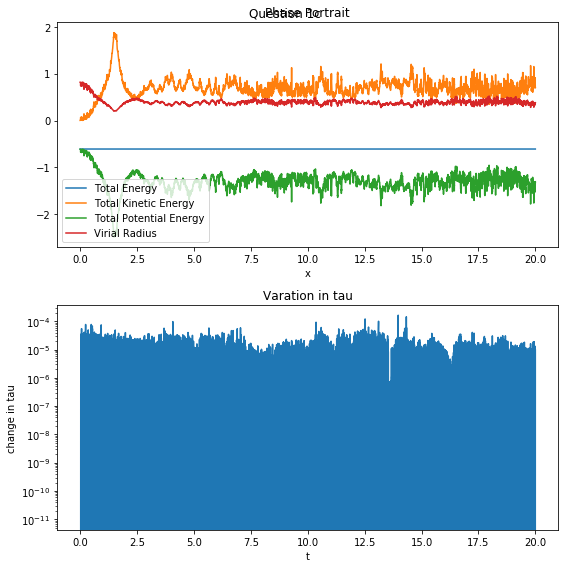

In [94]:
N = 50
seed = 12345
eps = .005
dt = .01
t_end = 20
v0 = .1
eta = .5

main(N, seed, eps, dt, t_end, v0, eta)

Q1d

In [38]:
def main(N, seed, eps, dt, t_end, v0, eta):
    if eps <= 0.0: eps = tiny
    dt0 = dt

    # Initial conditions.

    t = 0.0
    mass,pos,vel = initialize(N, seed, v0)
    steps = 0
    acc,tau = acc2(mass, pos, vel, eps**2)
    
    # Initial diagnostics.
    
    E0 = energy(mass, pos, vel, eps**2)
    print('Initial E =', E0)
    output(t, E0, mass, pos, vel, eps**2, steps)
    a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0], pos[1],
                                  vel[0], vel[1], eps**2)
    print('semimajor axis =', a, ' eccentricity =', e)

    # Run forward to specified time.

    tplot = []
    dEplot = []
    
    max_error = .0001
    t_increment = 0
    

    while t < t_end-0.5*dt:
        t,pos,vel,tau = step(t, mass, pos, vel, eps**2, dt0)
        steps += 1

        E = energy(mass, pos, vel, eps**2)
        tplot.append(t)

            
        if t >= t_increment:
                t_increment += .5
                print('Energy error is = {} at t = {}'.format(abs(E - E0),t))
                print('dt = {}'.format(dt))

        if abs(E-E0) >= max_error:
            print('Error greater than max error = {}, error = {}, at t = {}'.format(max_error, abs(E-E0), t))
            print('dt = {}'.format(dt))
            break
            
#             j = 0
#             for i in range(50):
#                 temp_pos = np.concatenate(pos[i],j)

    # Final diagnostics.

    print('dt = {}'.format(dt))
    print('\nThe number of steps = {}'.format(np.size(tplot)))

N = 50
seed = 12345
eps = .005
dt = .00005
t_end = 20
v0 = .1
eta = 10

main(N, seed, eps, dt, t_end, v0, eta)

Initial E = -0.6321712571999737
t = 0.0 dE = 0.0 steps = 0
semimajor axis = 0.19761059146559856  eccentricity = 0.8092791917638121
Energy error is = 2.5413005033669833e-13 at t = 5e-05
dt = 5e-05
Energy error is = 8.083060409891374e-08 at t = 0.5000499999999531
dt = 5e-05
Energy error is = 3.0996588040732576e-07 at t = 1.0000499999998982
dt = 5e-05
Energy error is = 7.074562702324982e-08 at t = 1.5000000000009532
dt = 5e-05
Energy error is = 1.3152942401895018e-08 at t = 2.000000000002008
dt = 5e-05
Energy error is = 9.810761092410303e-10 at t = 2.500000000000843
dt = 5e-05
Energy error is = 4.8843795008579605e-08 at t = 3.0000499999996775
dt = 5e-05
Energy error is = 4.70580311384694e-08 at t = 3.500049999998512
dt = 5e-05
Energy error is = 2.3638690305194388e-07 at t = 4.000049999997347
dt = 5e-05
Energy error is = 7.017259773256512e-09 at t = 4.500049999996182
dt = 5e-05
Energy error is = 4.931824215681502e-08 at t = 5.000049999995016
dt = 5e-05
Energy error is = 1.4885023880140125e

Q2

In [20]:
def initialize(n, seed, v0):
    mass = np.ones(n)/n
    pos = np.zeros((n,3))
    vel = np.zeros((n,3))
    if n == 2:
        pos = np.array([[1.0,0,0],[-1.0,0,0]])
        vel = np.array([[0,v0,0],[0,-v0,0]])
    return mass,pos,vel

def potential_energy(mass, pos, eps2):
    n = len(mass)
    pot = 0.0
    dx = np.zeros((n,3))
    for i in range(n):
        dx[i+1:] = pos[i+1:] - pos[i]
        dr2 = (dx[i+1:]**2).sum(axis=1) + eps2
        pot -= mass[i]*(mass[i+1:]/np.sqrt(dr2)).sum()
    return pot

def alt_potential_energy(mass, pos, eps2):
    n = len(mass)
    pot = 0.0
    for i in range(n):
        for j in range(i+1,n):
            dr2 = eps2
            for k in range(3):
                dr2 += (pos[i,k]-pos[j,k])**2
            pot -= mass[i]*mass[j]/math.sqrt(dr2)
    return pot

def kinetic_energy(mass, vel):
    return 0.5*(mass*(vel**2).sum(axis=1)).sum()

def alt_kinetic_energy(mass, vel):
    n = len(mass)
    kin = 0.0
    for i in range(n):
        vi2 = 0.0
        for k in range(3):
            vi2 += vel[i,k]**2
        kin += 0.5*mass[i]*vi2
    return kin

def energy(mass, pos, vel, eps2):
    T = kinetic_energy(mass, vel)
    U = potential_energy(mass, pos, eps2)
    return T+U

def output(t, E0, mass, pos, vel, eps2, steps):
    E = energy(mass, pos, vel, eps2)
    print('t =', t, 'dE =', E-E0, 'steps =', steps)

def acceleration(mass, pos, eps2):
    n = len(mass)
    acc = np.zeros((n,3))
    for i in range(n):
        dx   = pos - pos[i]
        dr2  = (dx**2).sum(axis=1) + eps2
        dr2i = 1./dr2
        dr3i = mass*np.sqrt(dr2i)*dr2i
        dx  *= dr3i.reshape(n,1)
        acc[i] = dx.sum(axis=0)
    return acc

def alt_acceleration(mass, pos, eps2):
    n = len(mass)
    acc = np.zeros((n,3))
    for i in range(n):
        for j in range(i+1,n):
            dr2 = eps2
            for k in range(3):
                dr2 += (pos[j,k]-pos[i,k])**2
            dr2i = 1./dr2
            dr3i = dr2i*math.sqrt(dr2i)
            for k in range(3):
                dxij = (pos[j,k]-pos[i,k])*dr3i
                acc[i,k] += mass[j]*dxij
                acc[j,k] -= mass[i]*dxij
    return acc

def step(t, mass, pos, vel, eps2, dt):

    # Second-order predictor-corrector.

    acc = acceleration(mass, pos, eps2)
    pos += dt*(vel+0.5*dt*acc)
    anew = acceleration(mass, pos, eps2)
    vel += 0.5*dt*(acc+anew)

    return t+dt,pos,vel

def orbital_elements(m1, m2, x1, x2, v1, v2, eps2):
    M = m1+m2
    x = x2-x1
    v = v2-v1
    r2 = (x**2).sum() + eps2
    v2 = (v**2).sum()
    E = 0.5*v2 - M/math.sqrt(r2)
    sma = -0.5*M/E
    h2 = ((np.cross(x,v))**2).sum()
    ecc = (1 + 2*E*h2/M**2)**0.5
    return sma, ecc, E, h2**0.5
    
tiny = 1.e-20
def main(N, seed, eps, dt, t_end, v0, dEtol):
    
    if eps <= 0.0: eps = tiny

    dt0 = dt		# dt0 is now a time step parameter

    # Initial conditions.

    t = 0.0
    mass,pos,vel = initialize(N, seed, v0)
    steps = 0
    
    # Initial diagnostics.
    
    E0 = energy(mass, pos, vel, eps**2)
    print('Initial E =', E0)
    output(t, E0, mass, pos, vel, eps**2, steps)
    a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0], pos[1],
                                  vel[0], vel[1], eps**2)
    print('semimajor axis =', a, ' eccentricity =', e)

    # Run forward to specified time.

    tplot = [0.0]
    dEplot = [0.0]
    hplot = [h]
    smaplot = [a]
    eccplot = [e]
    xplot = [pos[0][0]]
    yplot = [pos[0][1]]
    max_error = 0.0001
    t_increment = 0

    while t < t_end-0.5*dt:

        t0 = t
        pos0 = pos.copy()
        vel0 = vel.copy()

        t,pos,vel = step(t, mass, pos, vel, eps**2, dt)
        t,pos,vel = step(t, mass, pos, vel, eps**2, dt)
        E1 = energy(mass, pos, vel, eps**2)

        t2,pos2,vel2 = step(t0, mass, pos0, vel0, eps**2, 2*dt)
        E2 = energy(mass, pos2, vel2, eps**2)
        
        DeltaE = abs(E2 - E1)
        dtnext = dt*(DeltaE/dEtol)**(-1./3)
        
        
        if dtnext > 1.5*dt:
            dt = 1.5*dt
        else:
            dt = dtnext
            
#         r = math.sqrt(((pos[1]-pos[0])**2).sum())

#         E = energy(mass, pos, vel, eps**2)
#         a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0],
#                                       pos[1], vel[0], vel[1], eps**2)
        if t >= t_increment:
            t_increment += 1
            print('Energy error is = {} at t = {}'.format(abs(E1 - E0),t))
            print('dt = {}'.format(dt))

        if abs(E1-E0) >= max_error:
            print('Error greater than max error = {}, error = {}, at t = {}'.format(max_error, abs(E1-E0), t))
            print('dt = {}'.format(dt))
            break
            
        tplot.append(t)
        dEplot.append(E1-E0)

    print('dt = {}'.format(dt))
    print('\nThe number of steps = {}'.format(np.size(tplot)))
        
#         hplot.append(h)
#         smaplot.append(a)
#         eccplot.append(e)
#         xplot.append(pos[0][0])
#         yplot.append(pos[0][1])

    # Final diagnostics.
    
#     output(t, E0, mass, pos, vel, eps**2, steps)

#     plt.figure()

#     if 0:
#         plt.plot(xplot, yplot)
#     else:
#         plt.subplot(2,2,1)
#         plt.plot(tplot, dEplot)
#         plt.xlabel('time')
#         plt.ylabel('energy error')

#         plt.subplot(2,2,2)
#         plt.plot(tplot, hplot)
#         plt.xlabel('time')
#         plt.ylabel('angular momentum')

#         plt.subplot(2,2,3)
#         plt.plot(tplot, smaplot)
#         plt.xlabel('time')
#         plt.ylabel('semimajor axis')

#         plt.subplot(2,2,4)
#         plt.plot(tplot, eccplot)
#         plt.xlabel('time')
#         plt.ylabel('eccentricity')

    plt.tight_layout()
    plt.show()



In [21]:
N = 2
seed = 42
eps = 0
dt = .01
t_end = 50
v0 = .09
dEtol = (10e-8)

main(N, seed, eps, dt, t_end, v0, dEtol)

Initial E = -0.12095
t = 0.0 dE = 0.0 steps = 0
semimajor axis = 1.0334849111202977  eccentricity = 0.9352
Energy error is = 1.649159975247727e-11 at t = 0.02
dt = 0.015
Energy error is = 5.296700454349157e-07 at t = 1.0176824127081818
dt = 0.02349307639159917
Energy error is = 1.6440152285912557e-06 at t = 2.0214002537969367
dt = 0.01079314175584533
Energy error is = 5.334473701712472e-06 at t = 3.0015821016078643
dt = 0.0016960729310715231
Energy error is = 3.036399829348113e-06 at t = 4.000115980385609
dt = 0.0049009533208899374
Energy error is = 1.2467082627642956e-06 at t = 5.005104520210392
dt = 0.015307191571629719
Energy error is = 5.114795288002627e-07 at t = 6.009878740291028
dt = 0.030149146779080798
Energy error is = 5.76959544432154e-07 at t = 7.062397316653546
dt = 0.0353430342833685
Energy error is = 1.2818125572078287e-06 at t = 8.00968786521922
dt = 0.018029483679148976
Energy error is = 2.8497384778752854e-06 at t = 9.011475059734224
dt = 0.006788248929822984
Energy e

Q3


In [30]:
def initialize(n, seed, v0):
    mass = np.ones(n)/n
    mass_for_cm = np.ones((n,1))/n

    pos = np.zeros((n,3))
    vel = np.zeros((n,3))

    q = np.random.random(n)
    r = q**(1./3)
    mu = 2*np.random.random(n) - 1
    theta = np.arccos(mu)
    phi = 2*np.pi*np.random.random(n)
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)

    pos[:,0] = x
    pos[:,1] = y
    pos[:,2] = z

    mu = 2*np.random.random(n) - 1
    theta = np.arccos(mu)
    phi = 2*np.pi*np.random.random(n)
    vx = v0*np.sin(theta)*np.cos(phi)
    vy = v0*np.sin(theta)*np.sin(phi)
    vz = v0*np.cos(theta)

    vel[:,0] = vx
    vel[:,1] = vy
    vel[:,2] = vz

    M = mass.sum()

    rcm = (1/M)*(mass_for_cm*pos).sum(axis = 0)
    vcm = (1/M)*(mass_for_cm*vel).sum(axis = 0)  

    pos = pos - rcm
    vel = vel - vcm
    
    return mass,pos,vel

tiny = 1.e-20
def main(N, seed, eps, dt, t_end, v0, dEtol):
    
    if eps <= 0.0: eps = tiny

    dt0 = dt		# dt0 is now a time step parameter

    # Initial conditions.

    t = 0.0
    mass,pos,vel = initialize(N, seed, v0)
    steps = 0
    
    # Initial diagnostics.
    
    E0 = energy(mass, pos, vel, eps**2)
    print('Initial E =', E0)
    output(t, E0, mass, pos, vel, eps**2, steps)
    a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0], pos[1],
                                  vel[0], vel[1], eps**2)
    print('semimajor axis =', a, ' eccentricity =', e)

    # Run forward to specified time.

    tplot = [0.0]
    dEplot = [0.0]
    hplot = [h]
    smaplot = [a]
    eccplot = [e]
    xplot = [pos[0][0]]
    yplot = [pos[0][1]]
    max_error = 0.0001
    t_increment = 0

    step_count = 0
    while t < t_end-0.5*dt:

        t0 = t
        pos0 = pos.copy()
        vel0 = vel.copy()

        t,pos,vel = step(t, mass, pos, vel, eps**2, dt)
        t,pos,vel = step(t, mass, pos, vel, eps**2, dt)
        E1 = energy(mass, pos, vel, eps**2)
    
    
        step_count += 1
        
        t2,pos2,vel2 = step(t0, mass, pos0, vel0, eps**2, 2*dt)
        E2 = energy(mass, pos2, vel2, eps**2)
        
        DeltaE = abs(E2 - E1)
        dtnext = dt*(DeltaE/dEtol)**(-1./3)
        
        
        if dtnext > 1.5*dt:
            dt = 1.5*dt
        else:
            dt = dtnext
            
#         r = math.sqrt(((pos[1]-pos[0])**2).sum())

#         E = energy(mass, pos, vel, eps**2)
#         a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0],
#                                       pos[1], vel[0], vel[1], eps**2)
        if t >= t_increment:
            t_increment += .5
            print('Energy error is = {} at t = {}'.format(abs(E1 - E0),t))
            print('dt = {}'.format(dt))

        if abs(E1-E0) >= max_error:
            print('Error greater than max error = {}, error = {}, at t = {}'.format(max_error, abs(E1-E0), t))
            print('dt = {}'.format(dt))
            break
            
        tplot.append(t)
        dEplot.append(E1-E0)

    print('dt = {}'.format(dt))
    print('\nThe number of steps = {}'.format(step_count))
        
#         hplot.append(h)
#         smaplot.append(a)
#         eccplot.append(e)
#         xplot.append(pos[0][0])
#         yplot.append(pos[0][1])

    # Final diagnostics.
    
#     output(t, E0, mass, pos, vel, eps**2, steps)

#     plt.figure()

#     if 0:
#         plt.plot(xplot, yplot)
#     else:
#         plt.subplot(2,2,1)
#         plt.plot(tplot, dEplot)
#         plt.xlabel('time')
#         plt.ylabel('energy error')

#         plt.subplot(2,2,2)
#         plt.plot(tplot, hplot)
#         plt.xlabel('time')
#         plt.ylabel('angular momentum')

#         plt.subplot(2,2,3)
#         plt.plot(tplot, smaplot)
#         plt.xlabel('time')
#         plt.ylabel('semimajor axis')

#         plt.subplot(2,2,4)
#         plt.plot(tplot, eccplot)
#         plt.xlabel('time')
#         plt.ylabel('eccentricity')

    plt.tight_layout()
    plt.show()




In [34]:
N = 50
seed = 12345
eps = .005
dt = .01
t_end = 20
dEtol = (10e-8)/2

main(N, seed, eps, dt, t_end, v0, dEtol)

Initial E = -0.6224128509010608
t = 0.0 dE = 0.0 steps = 0
semimajor axis = 0.9750175210654083  eccentricity = 0.9036295904145996
Energy error is = 2.663256567503325e-07 at t = 0.02
dt = 0.003977648929110488
Energy error is = 1.928018972807699e-06 at t = 0.5000642694478166
dt = 8.702223516167413e-05
Energy error is = 1.1890672296788196e-06 at t = 1.0000235229223124
dt = 2.255966688423706e-05
Energy error is = 1.954894372713234e-06 at t = 1.5001779088074028
dt = 0.0001148934266621503
Energy error is = 2.684570402755604e-06 at t = 2.0004923703249746
dt = 0.00036419776750604025
Energy error is = 3.5826091923096826e-06 at t = 2.5001561803488874
dt = 9.314270252532509e-05
Energy error is = 1.6817603620822297e-06 at t = 3.0001399602442804
dt = 0.00016395109660205515
Energy error is = 2.44582827257922e-06 at t = 3.5000780562477933
dt = 5.421263733328397e-05
Energy error is = 5.179535876309593e-06 at t = 4.00000915098088
dt = 6.583381444854497e-05
Energy error is = 1.0195742692009624e-05 at t 

In [ ]:
N = 10
a_temp = ['a','b','c','d','e']
N = 5
for i_temp in range(N):
    for j_temp in range(i_temp + 1, N):
        print(a_temp[i_temp], a_temp[j_temp])


In [26]:
a = [1,2,3]
len(a)

3